In [1]:
# Load libraries

import os
import pandas as pd
import torch
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Load the model from hugging face

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", clean_up_tokenization_spaces = True)
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)

In [ ]:
# Set device to GPU if available, otherwise CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(torch.cuda.is_available())

In [ ]:
model.requires_grad_(False) #Freeze the weights 

Pre-trained weights are loaded for the layers inside the `BertModel` (embeddings, encoder, pooler). These weights have been trained on clinical text data when the model is loaded from Hugging Face, such as Bio_ClinicalBERT.

The classifier, which includes `classifier.bias` and `classifier.weight`, is not pre-trained. It is newly initialized since the model does not yet know the specific task being performed (e.g., binary classification). This layer requires training (fine-tuning) on the specific task to achieve optimal performance.

The weights of the pre-trained model's parameters can be frozen to prevent them from being updated during backpropagation while fine-tuning.

In [ ]:
# Load the train dataset
train = pd.read_csv("train.csv").dropna()

# Ensure that labels are integers
train['label'] = train['label'].astype(int)

# Sample 1000 rows from the dataset
# train = train.sample(1000)

# Display dataset information
print(f"Dataset info: \n {train.info()}")
print(f"Dataset first 5 rows: \n {train.head(5)}")

In [6]:
# Extract texts and labels from the dataset
texts = train['text'].tolist()  # Convert the 'text' column to a list
labels = train['label'].tolist()  # Convert the 'label' column to a list

# Tokenize the dataset with padding, truncation, and conversion to tensors
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

# Convert labels to tensor
labels = torch.tensor(labels)  # Convert list of labels to a tensor

# Create TensorDataset using tokenized inputs and labels
data = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

# Create DataLoader for the entire dataset
dataLoader = DataLoader(data, batch_size=16)

# Set the model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Accuracy: 0.4780
Misclassification Error Rate: 0.5220

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.12      0.00      0.01       510
     Class 1       0.48      0.97      0.65       490

    accuracy                           0.48      1000
   macro avg       0.30      0.49      0.33      1000
weighted avg       0.30      0.48      0.32      1000



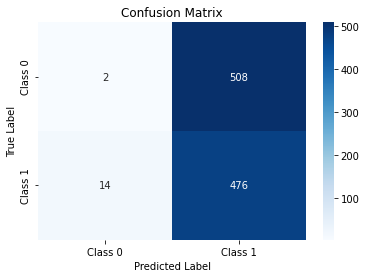

In [7]:
# Function to predict labels using the model without fine-tuning
def predictLabels(dataLoader):
    predictions = []
    for batch in dataLoader:
        bInputIds, bInputMask, _ = [t.to(device) for t in batch]  # Move to device
        with torch.no_grad():  # No backpropagation
            outputs = model(bInputIds, attention_mask=bInputMask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Get the predicted labels and move to CPU
            predictions.extend(preds)
    return predictions

# Predict labels for the entire dataset
yPred = predictLabels(dataLoader)

# Convert labels to CPU for evaluation (if they are on GPU)
labels_cpu = labels.cpu().numpy() if labels.is_cuda else labels

# Calculate accuracy
accuracy = accuracy_score(labels_cpu, yPred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate misclassification error rate
misclassificationErrorRate = 1 - accuracy
print(f"Misclassification Error Rate: {misclassificationErrorRate:.4f}")

# Generate a classification report (precision, recall, F1-score)
report = classification_report(labels_cpu, yPred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n")
print(report)

# Generate confusion matrix
confMatrix = confusion_matrix(labels_cpu, yPred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Bio_ClinicalBERT, a model pre-trained for tasks like language modeling and general understanding of clinical text, lacks a pre-trained classification head necessary for tasks like sequence classification. In this case, the model's classification layer (`classifier.weight` and `classifier.bias`) is randomly initialized, leading to poor performance when applied to a binary classification task without fine-tuning. The model shows a strong imbalance in prediction, performing poorly on Class 0 with low precision, recall, and F1-score, while Class 1 predictions are more accurate but still not optimal. This highlights the need for fine-tuning the classification head to improve its overall accuracy and balance between classes.

In [8]:
model.classifier.requires_grad_(True) # Only the gradients of the classification layer should be updated while fine tuning

# Print all parameters and their requires_grad status
print("\n".join([f"Parameter: {name} | Requires Grad: {param.requires_grad}" for name, param in model.named_parameters()]))

Parameter: bert.embeddings.word_embeddings.weight | Requires Grad: False
Parameter: bert.embeddings.position_embeddings.weight | Requires Grad: False
Parameter: bert.embeddings.token_type_embeddings.weight | Requires Grad: False
Parameter: bert.embeddings.LayerNorm.weight | Requires Grad: False
Parameter: bert.embeddings.LayerNorm.bias | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.query.weight | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.query.bias | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.key.weight | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.key.bias | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.value.weight | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.self.value.bias | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.output.dense.weight | Requires Grad: False
Parameter: bert.encoder.layer.0.attention.output.dense.bias | Requ

True
Epoch 1/2 completed. Loss: 0.7108
Epoch 2/2 completed. Loss: 0.6687
Model weights saved to /home/22058122/BioClinicalBERT/fine_tune/fine_tuned_clinical_bert_sequentialclassifier_{epoch}.pt
Training completed in 23.03 seconds.


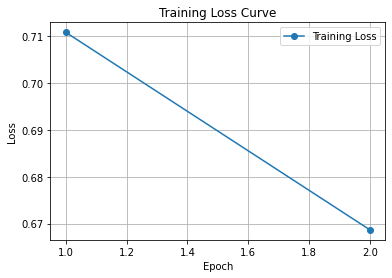

Testing completed in 2.60 seconds.
Accuracy: 0.6550
Misclassification Error Rate: 0.3450

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.98      0.39      0.56       112
     Class 1       0.56      0.99      0.72        88

    accuracy                           0.66       200
   macro avg       0.77      0.69      0.64       200
weighted avg       0.79      0.66      0.63       200



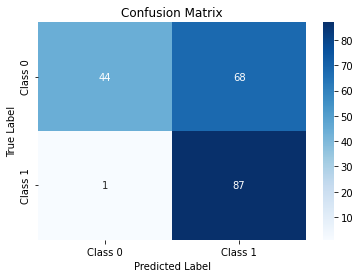

In [9]:
# Check if CUDA is available and move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(torch.cuda.is_available())

# Split the data into 20% for training and 80% for testing
xTrain, xTest, yTrain, yTest = train_test_split(inputs['input_ids'], labels, test_size=0.8, random_state=13)
trainMasks, testMasks = train_test_split(inputs['attention_mask'], test_size=0.8, random_state=13)

# Create DataLoader for the training and testing datasets
trainData = TensorDataset(xTrain, trainMasks, yTrain)
testData = TensorDataset(xTest, testMasks, yTest)
trainDataLoader = DataLoader(trainData, batch_size=16)
testDataLoader = DataLoader(testData, batch_size=16)

# Fine-tuning settings
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 2001
loss_values = []

# Measure training time
start_training_time = time.time()

# Fine-tuning loop (on the 20% training set)
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in trainDataLoader:
        bInputIds, bInputMask, bLabels = [b.to(device) for b in batch]  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(bInputIds, attention_mask=bInputMask, labels=bLabels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Calculate average loss for this epoch
    avg_epoch_loss = epoch_loss / len(trainDataLoader)
    loss_values.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} completed. Loss: {avg_epoch_loss:.4f}")

# Save the fine-tuned model weights after training

# Use os.path.expanduser to expand the '~' to the full path
model_save_path = os.path.expanduser("~/BioClinicalBERT/fine_tune/fine_tuned_clinical_bert_sequentialclassifier_{epoch}.pt")
# Save the model at the specified path
torch.save(model.state_dict(), model_save_path.format(epoch=epoch))
# model_save_path = "~/BioClinicalBERT/fine_tune/fine_tuned_clinical_bert_ipynb.pt"
# torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

end_training_time = time.time()
training_time = end_training_time - start_training_time
print(f"Training completed in {training_time:.2f} seconds.")

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Measure testing time
start_testing_time = time.time()

# Set model to evaluation mode for testing
model.eval()

# Function to predict labels using the model
def predictLabels(dataLoader):
    predictions = []
    for batch in dataLoader:
        bInputIds, bInputMask, _ = [b.to(device) for b in batch]  # Move data to GPU
        with torch.no_grad():
            outputs = model(bInputIds, attention_mask=bInputMask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Move back to CPU for evaluation
            predictions.extend(preds)
    return predictions

# Predict labels for the test set (80% data)
yPred = predictLabels(testDataLoader)

end_testing_time = time.time()
testing_time = end_testing_time - start_testing_time
print(f"Testing completed in {testing_time:.2f} seconds.")

# Calculate accuracy
accuracy = accuracy_score(yTest, yPred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate misclassification error rate
misclassificationErrorRate = 1 - accuracy
print(f"Misclassification Error Rate: {misclassificationErrorRate:.4f}")

# Generate a classification report (precision, recall, F1-score)
report = classification_report(yTest, yPred, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:\n")
print(report)

# Generate confusion matrix
confMatrix = confusion_matrix(yTest, yPred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()